# Geonames modifications

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Read the CSV file into a pandas dataframe

In [4]:
header = ['geonameid','name','asciiname','alternatenames','latitude','longitude','feature class','feature code','country code','cc2','admin1 code','admin2 code','admin3 code','admin4 code','population','elevation','dem','timezone','modification date']
geonames = pd.read_csv('D:/Geonames/allCountries.txt', delimiter='\t', header=None, names=header, low_memory=False)

## Create a simple histogram using the modification date

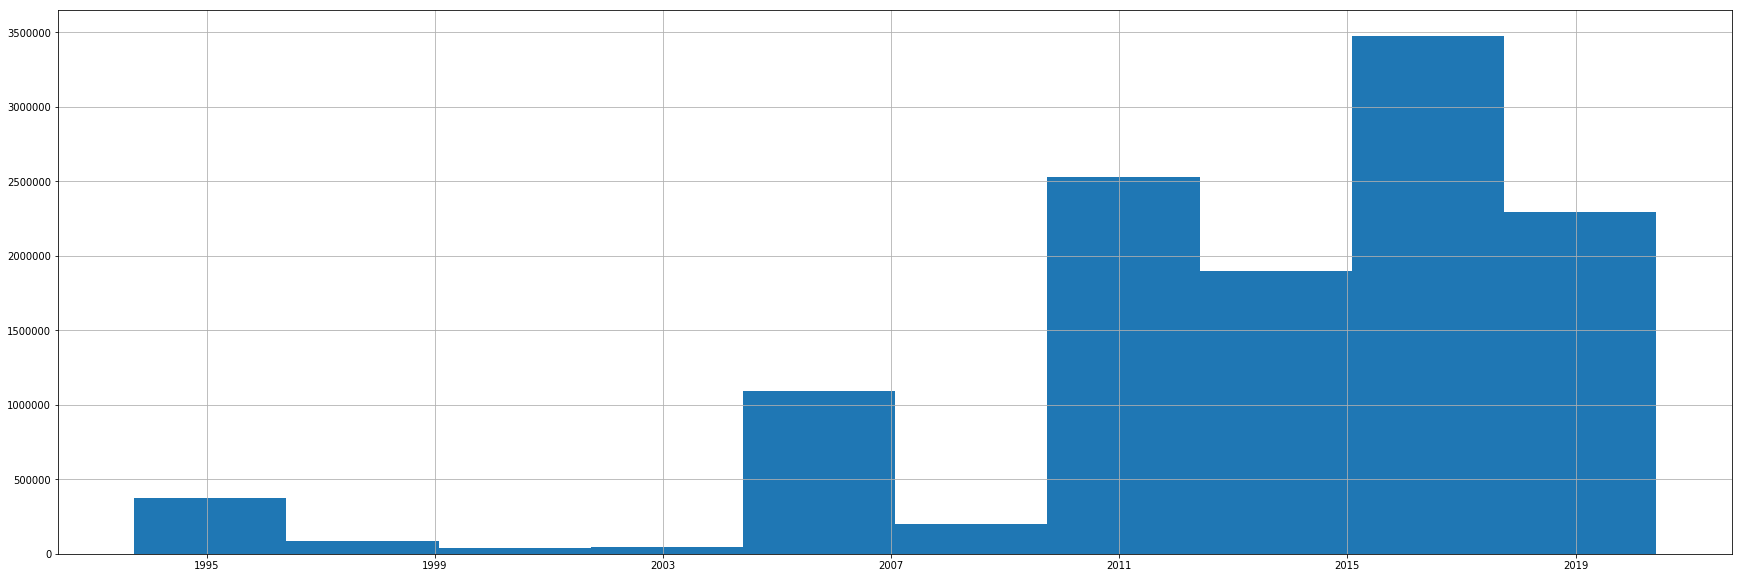

In [14]:
dates = pd.to_datetime(geonames['modification date'])
plt.rcParams['figure.figsize'] = (30, 10)
dates.hist()
geonames["dates"] = dates

## Filter by month and year

In [70]:
import calendar
import datetime

def filter_month_year(geonames, year, month):
    (weekday, days) = calendar.monthrange(year, month)
    first_date = datetime.datetime(year, month, 1)
    last_date = datetime.datetime(year, month, days, 23, 59, 59)
    filter = (first_date <= geonames['dates']) & (geonames['dates'] <= last_date)
    return geonames.loc[filter]

def filter_day_month_year(geonames, year, month, day):
    filter = datetime.datetime(year, month, day) == geonames['dates']
    return geonames.loc[filter]

#geonames_filtered = filter_day_month_year(geonames, 2020, 1, 1)
geonames_filtered = filter_month_year(geonames, 2020, 1)

## Create a simple focus map

In [71]:
import arcgis
from arcgis.gis import GIS
from arcgis.features import FeatureLayer
from arcgis.features import GeoAccessor
from arcgis.features import SpatialDataFrame
from arcgis.geometry.filters import intersects

gis = GIS()
focus_map = gis.map()
focus_map.basemap = 'osm'
focus_map

MapView(layout=Layout(height='400px', width='100%'))

## Create a spatial data frame

In [72]:
def create_spatial_dataframe(geonames):
    geonames_copy = geonames.copy()
    return GeoAccessor.from_xy(geonames_copy, x_column="longitude", y_column="latitude", sr=4326)
    
geonames_spatial = create_spatial_dataframe(geonames_filtered)

In [73]:
def create_spatial_bins(geonames_spatial):
    hex_bins_url = "https://services.arcgis.com/P3ePLMYs2RVChkJx/ArcGIS/rest/services/Global_Hex_Grid_500km/FeatureServer/0"
    hex_bins_layer = FeatureLayer(hex_bins_url)
    hex_bins_features_dict = {}
    for record_index, record in geonames_spatial.iterrows():
        record_shape = record['SHAPE']
        intersect_filter = intersects(record_shape, sr=record_shape.spatialReference)
        hex_ids_result = hex_bins_layer.query(geometry_filter=intersect_filter, return_ids_only=True)
        hex_object_ids = hex_ids_result['objectIds']
        if 0 < len(hex_object_ids):
            for hex_object_id in hex_object_ids:
                if hex_object_id in hex_bins_features_dict:
                    hex_bin_feature_entry = hex_bins_features_dict[hex_object_id]
                    hex_bin_feature_entry['hit_count'] = hex_bin_feature_entry['hit_count'] + 1
                    hex_bins_features_dict[hex_object_id] = hex_bin_feature_entry
                else:
                    hex_bins_features_dict[hex_object_id] = { 'hit_count': 1 }
        
    object_ids = list(hex_bins_features_dict)
    object_ids_filter = ",".join([str(oid) for oid in object_ids])
    hex_features_result = hex_bins_layer.query(object_ids=object_ids_filter)
    hex_spatial_dataframe = hex_features_result.sdf
    hit_counts = []
    for object_id in object_ids:
        hit_counts.append(hex_bins_features_dict[object_id]['hit_count'])
    hex_spatial_dataframe['hit_count'] = hit_counts
    return hex_spatial_dataframe

#geonames_aggregated = create_spatial_bins(geonames_spatial)
#geonames_aggregated
#focus_map.add_layer(geonames_aggregated)
geonames_aggregated.spatial.plot(focus_map, renderer_type='c', class_count=5, col='hit_count', cmap='Wistia', alpha=0.7)

True

In [58]:
type(geonames_aggregated)
#geonames_spatial['SHAPE']

list